# Object Detection

## First let's look at the dataset

## And try to visualize the bounding box

In [1]:
# my tool box for pytorch
from matchbox import *

In [2]:
DATA = "/data/coco/"

IMG = DATA+"val2017/"
ANN = DATA+"annotations/instances_val2017.json"

%ls {IMG}|wc -l

    5000


In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import matplotlib.text as text
import numpy as np
import pandas as pd
import json
from glob import glob
from PIL import Image

In [4]:
jsfile = open(ANN).read()

jsdict = json.loads(jsfile)

jsdict.keys()

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

#### Image table, with image url , image id, yup , that's all we need now

In [5]:
imgdf=pd.DataFrame(jsdict["images"])
imgdf.head()

,coco_url,date_captured,file_name,flickr_url,height,id,license,width
0,http://images.cocodataset.org/val2017/00000039...,2013-11-14 17:02:52,000000397133.jpg,http://farm7.staticflickr.com/6116/6255196340_...,427,397133,4,640
1,http://images.cocodataset.org/val2017/00000003...,2013-11-14 20:55:31,000000037777.jpg,http://farm9.staticflickr.com/8429/7839199426_...,230,37777,1,352
2,http://images.cocodataset.org/val2017/00000025...,2013-11-14 22:32:02,000000252219.jpg,http://farm4.staticflickr.com/3446/3232237447_...,428,252219,4,640
3,http://images.cocodataset.org/val2017/00000008...,2013-11-14 23:11:37,000000087038.jpg,http://farm8.staticflickr.com/7355/8825114508_...,480,87038,1,640
4,http://images.cocodataset.org/val2017/00000017...,2013-11-14 23:16:55,000000174482.jpg,http://farm8.staticflickr.com/7020/6478877255_...,388,174482,6,640


#### An annotation table, in this case, we use "bbox"

In [6]:
ann_df=pd.DataFrame(jsdict["annotations"])
ann_df.head()

,area,bbox,category_id,id,image_id,iscrowd,segmentation
0,702.10575,"[473.07, 395.93, 38.65, 28.67]",18,1768,289343,0,"[[510.66, 423.01, 511.72, 420.03, 510.45, 416...."
1,27718.47630,"[272.1, 200.23, 151.97, 279.77]",18,1773,61471,0,"[[289.74, 443.39, 302.29, 445.32, 308.09, 427...."
2,78969.31690,"[124.71, 196.18, 372.85, 356.81]",18,2551,472375,0,"[[147.76, 396.11, 158.48, 355.91, 153.12, 347...."
3,108316.66515,"[112.71, 154.82, 367.29, 479.35]",18,3186,520301,0,"[[260.4, 231.26, 215.06, 274.01, 194.33, 307.6..."
4,75864.53530,"[200.61, 89.65, 400.22, 251.02]",18,3419,579321,0,"[[200.61, 253.97, 273.19, 318.49, 302.43, 336...."


#### A category table

In [7]:
cat_df = pd.DataFrame(jsdict["categories"])
idx2name = dict(zip(cat_df["id"],cat_df["name"]))
id2idx = dict(enumerate(cat_df["id"]))
idx2id = dict((v,k) for k,v in enumerate(cat_df["id"]))

In [8]:
len(idx2name)

80

In [9]:
urls = glob(IMG+"/*")

In [10]:
urls[:5]

['/data/coco/val2017/000000000139.jpg',
 '/data/coco/val2017/000000000285.jpg',
 '/data/coco/val2017/000000000632.jpg',
 '/data/coco/val2017/000000000724.jpg',
 '/data/coco/val2017/000000000776.jpg']

#### Get the image id from image url

In [11]:
rdimg = np.random.choice(urls)
def get_id(url):
    return int(url.split("/")[-1].split(".")[0])

#### Get the bounding box data from annotation

In [12]:
def get_bb(rdimg):
    match = ann_df[ann_df["image_id"]==get_id(rdimg)][["bbox","category_id"]]
    return list(match["bbox"]),list(match["category_id"])

In [13]:
get_bb(rdimg)

([[37.33, 46.74, 59.73, 73.17],
  [71.41, 26.87, 182.66, 116.52],
  [348.21, 0.76, 151.29, 72.23],
  [246.68, 37.38, 55.57, 44.58],
  [209.88, 28.09, 61.94, 31.86],
  [18.71, 50.92, 46.66, 59.08],
  [274.63, 5.24, 133.95, 324.02],
  [0.17, 67.93, 19.39, 34.17],
  [0.0, 64.28, 19.33, 10.81]],
 [3, 3, 3, 3, 3, 3, 11, 3, 3])

#### Picture boxes by loops into the picture

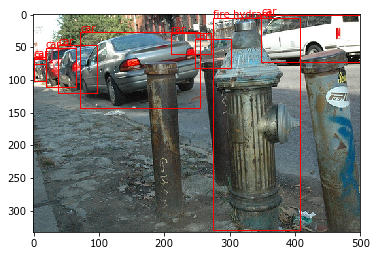

In [14]:
fig,ax = plt.subplots(1)
ax.imshow(Image.open(rdimg))
bbs,cids = get_bb(rdimg)
for i in range(len(bbs)):
    bb=bbs[i]
    # format of the bb: x, y, width, height
    rect = patches.Rectangle((bb[0],bb[1]),bb[2],bb[3],linewidth=1,edgecolor='r',facecolor='none')

    ax.add_patch(rect)
    # format of bb 
    ax.text(bb[0],bb[1],idx2name[cids[i]],dict({"color":"#ff0000"}))


## You Only Look Once

### Introduction

From the paper [You Only Look Once: Unified, Real-Time Object Detection](http://arxiv.org/abs/1506.02640)

We divid the image to the grid boxes of size $S*S$

In each grid cell, we predict $B$ bounding boxes 

Each $B$ we have 5 predictions $x, y, w, h$ and confidence, 

$x,y$ relative to the grid box.$w, h$ relative to the entire picture.

Each grid cell, we predict class probability $Pr(Class_{i}|Object)$.

Then **class specified** confidence scores, when at test time we shall calculate, are:

$Pr(Class_{i}|Object)*Pr(Object)* IOU^{truth}_{pred}=Pr(Class_{i})* IOU^{truth}_{pred}$

IOU: **Intersection Over Union**

So the prediction are encoded in a tensor of size $S*S*(B*5+C)$

### YOLO style with anchor box

In [15]:
anc_cluster = np.array([[10,13],[16,30],[33,23],[30,61],[62,45],[59,119],[116,90],[156,198],[373,326]])
anc_cluster

array([[ 10,  13],
       [ 16,  30],
       [ 33,  23],
       [ 30,  61],
       [ 62,  45],
       [ 59, 119],
       [116,  90],
       [156, 198],
       [373, 326]])

#### Get resized bb

In [111]:
SIZE = 416 # 13 * 32
HEIGHT = 416
WIDTH = 416
FEAT_W = int(416/32)
FEAT_H = int(416/32)

BOX              = 5
ANCHORS          = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]

VEC_LEN = 85

anchor = torch.from_numpy(np.array(ANCHORS,dtype=np.float)).view(1,1,1,5,2).type(torch.FloatTensor)

ANC_ARR = np.array(ANCHORS).reshape(5,2)

In [18]:
ratio_df = imgdf[["id"]]

In [19]:
ratio_df["width"] = SIZE/imgdf["width"].values
ratio_df["height"] = SIZE/imgdf["height"].values

/Users/zhangxiaochen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/zhangxiaochen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [20]:
def iou(cor1,cor2):
    """Intersection over union"""
    x1,y1,w1,h1 = cor1
    x2,y2,w2,h2 = cor2
    inter = max(min(x1+w1,x2+w2)-max(x1,x2),0)*max(min(y1+h1,y2+h2)-max(y1,y2),0)
    union = (w1*h1+w2*h2)-inter
    return inter/union

In [21]:
np.reshape(ANCHORS, [BOX,2])

array([[0.57273 , 0.677385],
       [1.87446 , 2.06253 ],
       [3.33843 , 5.47434 ],
       [7.88282 , 3.52778 ],
       [9.77052 , 9.16828 ]])

In [22]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

In [23]:
def p_structure(md):
    """Print out the model structure"""
    for par in md.parameters():
        print(par.size())

def p_count(md):
    """count the parameters in side a pytorch module"""
    allp=0
    for p in md.parameters():allp+=np.product(p.data.numpy().shape)
    return allp

##### Random Try

In [24]:
cell_y=torch.arange(0,FEAT_W)

cell_y=cell_y.repeat(FEAT_H).view(1,FEAT_H,FEAT_W,1,1)

cell_x=cell_y.transpose(1,2)
#cell_x,cell_y
cell_grid=torch.cat([cell_x,cell_y],dim=-1)

#### Prepare bb data

In [25]:
def df_data(imgdf,ann_df):
    """
    imgdf:
    A dataframe about images, fields: "id","file_name","height","width"
    ann_df:
    A dataframe about annotation, fields: "image_id","category_id","bbox",
    The field "bbox" is a list of 4 values: x,y,height, width of the bounding box
    """
    data_df=pd.merge(ann_df[["bbox","category_id","image_id"]],
                     imgdf[["id","file_name","height","width"]],
                     left_on="image_id",right_on="id")
    
    data_df["cate_id_oh"] = data_df["category_id"].apply(lambda x:idx2id[x])
    
    print("total data rows",len(data_df))
    return data_df

data_df = df_data(imgdf,ann_df)
data_df.head()

total data rows 36781


,bbox,category_id,image_id,id,file_name,height,width,cate_id_oh
0,"[473.07, 395.93, 38.65, 28.67]",18,289343,289343,000000289343.jpg,640,529,16
1,"[204.01, 235.08, 60.84, 177.36]",1,289343,289343,000000289343.jpg,640,529,0
2,"[0.43, 499.79, 339.79, 106.45]",15,289343,289343,000000289343.jpg,640,529,13
3,"[204.42, 304.1, 52.51, 152.76]",2,289343,289343,000000289343.jpg,640,529,1
4,"[272.1, 200.23, 151.97, 279.77]",18,61471,61471,000000061471.jpg,480,640,16


##### Resize the bounding box

In [26]:
bbox_array = np.array(data_df.bbox.tolist())
wh_array = data_df[["width","height"]].as_matrix()

def re_calibrate(bbox_array,wh_array):
    """return the resized bbox array"""
    bb_resized = (bbox_array/np.concatenate([wh_array,wh_array],axis=-1)) *SIZE
    
    true_bb = bb_resized/32
    # swith xy as left top conner to center point
    true_bb[...,:2]=true_bb[...,:2]+true_bb[...,2:]/2
    # Labels' Anchor positions on the grid map
    grid_bbxy = np.floor(true_bb[...,:2])
    return bb_resized,true_bb,grid_bbxy

bb_resized,true_bb,grid_bbxy = re_calibrate(bbox_array,wh_array)
true_bbxy,true_bbwh = true_bb[...,:2],true_bb[...,2:]

In [27]:
bb_resized

array([[3.72017240e+02, 2.57354500e+02, 3.03939509e+01, 1.86355000e+01],
       [1.60431304e+02, 1.52802000e+02, 4.78439319e+01, 1.15284000e+02],
       [3.38147448e-01, 3.24863500e+02, 2.67207259e+02, 6.91925000e+01],
       ...,
       [1.62207500e+02, 4.21395816e+01, 1.08140500e+02, 3.10111464e+02],
       [5.95660000e+01, 1.67414000e+02, 1.17754000e+02, 1.34446000e+02],
       [5.33561600e+01, 1.14868468e+02, 3.61886720e+02, 2.95822222e+02]])

In [28]:
def find_best_anchors(true_bbwh):
    iou_score = []
    for b in range(BOX):
        wh_anc = np.tile(ANC_ARR[b],[true_bbwh.shape[0],1])
        true_area = true_bbwh.prod(axis=-1)
        anc_area = wh_anc.prod(axis=-1)
    
        inter_area = np.min([wh_anc,true_bbwh],axis=0).prod(axis=-1)
    
        union_area = true_area + anc_area - inter_area
        iou_score.append(inter_area/union_area)
    best_anchor_idx = np.array(iou_score).T.argmax(axis=-1)
    return best_anchor_idx

best_anchor_idx = find_best_anchors(true_bbwh)

##### Index to onehot

In [59]:
cate_idx = data_df["cate_id_oh"].as_matrix()

cate_oh = np.eye(cate_idx.max()+1)[cate_idx]

In [60]:
true_vec = np.concatenate([true_bb,np.ones((true_bb.shape[0],1)),cate_oh],axis=-1)

In [61]:
true_adj = b2t(true_vec)

In [62]:
true_adj = np.tile(true_adj[:,np.newaxis,np.newaxis,np.newaxis,:],[1,FEAT_W,FEAT_H,BOX,1])

vec_loc = np.concatenate([grid_bbxy,np.expand_dims(best_anchor_idx,axis=-1)],axis=-1).astype(np.int)

#### Reverse adjust funtion to get train labels

* adj function

$\large b_{x}=\sigma(t_{x})+c_{x}$

$\large b_{y}=\sigma(t_{y})+c_{y}$

$\large b_{w}=p_{w}e^{w}$

$\large b_{h}=p_{h}e^{h}$

* reversed

$\large t_{x}=-ln(\frac{b_{x}-c_{x}}{1-b_{x}+c_{x}})$

$\large t_{y}=-ln(\frac{b_{y}-c_{y}}{1-b_{y}+c_{y}})$

$\large t_{w}=ln(\frac{b_{w}}{p_{w}})$

$\large t_{h}=ln(\frac{b_{h}}{p_{h}})$

In [64]:
def mask_from_loca(vec_loc):
    """
    return mask tensor [batch_size,grid_w,grid_h,box] according to grid location
    """
    mask=np.eye(BOX)[vec_loc[:,2:].reshape(-1)][:,np.newaxis,np.newaxis,:]
    mask_w=np.eye(FEAT_W)[vec_loc[:,:1].reshape(-1)][:,:,np.newaxis,np.newaxis]
    mask_h=np.eye(FEAT_H)[vec_loc[:,1:2].reshape(-1)][:,np.newaxis,:,np.newaxis]

    mask = np.tile(mask,[1,FEAT_W,FEAT_H,1])
    mask *= np.tile(mask_w,[1,1,FEAT_H,BOX])
    mask *= np.tile(mask_h,[1,FEAT_W,1,BOX])
    
    return mask

def true_label(true_adj,vec_loc):
    true_adj = b2t_wh(true_adj)
    mask = mask_from_loca(vec_loc)
    true_adj *= np.tile(mask[:,:,:,:,np.newaxis],[1,1,1,1,true_adj.shape[-1]])
    return true_adj, mask

def b2t(x):
    x[...,:2] = -np.log(x[...,:2]-np.floor(x[...,:2]))/(1-x[...,:2]+np.floor(x[...,:2]))
    return x

def b2t_wh(x):
    x[...,2:4] = np.log(x[...,2:4]/np.tile(ANC_ARR,[len(x),FEAT_W,FEAT_H,1,1]))
    return x

In [65]:
true_y,mask_ = true_label(true_adj[:16],vec_loc[:16])

vec_loc[0],true_y[0][tuple(vec_loc[0])]

(array([12,  8,  0]),
 array([ 2.55476389,  1.64756468,  0.50584858, -0.15115206,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.     

In [176]:
torch.max(torch.rand(5,2)-1,0)

(
 -0.5568 -0.3906
 [torch.FloatTensor of size 1x2], 
  1  3
 [torch.LongTensor of size 1x2])

In [186]:
rd=torch.rand(5,2)-1
rd2=torch.rand(5,2)-1

In [187]:
rd,rd2

(
 -0.6265 -0.5653
 -0.5602 -0.6669
 -0.7574 -0.3723
 -0.7993 -0.6348
 -0.4341 -0.0166
 [torch.FloatTensor of size 5x2], 
 -0.3194 -0.5838
 -0.8079 -0.9925
 -0.9020 -0.8007
 -0.1619 -0.8673
 -0.1271 -0.2970
 [torch.FloatTensor of size 5x2])

#### Feature Extractor

In [87]:
from collections import OrderedDict
from torchvision.models.densenet import  _DenseBlock,_DenseLayer,_Transition

class DenseNet(nn.Module):
    r"""Densenet-BC model class, based on
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_
    Args:
        growth_rate (int) - how many filters to add each layer (`k` in paper)
        block_config (list of 4 ints) - how many layers in each pooling block
        num_init_features (int) - the number of filters to learn in the first convolution layer
        bn_size (int) - multiplicative factor for number of bottle neck layers
          (i.e. bn_size * k features in the bottleneck layer)
        drop_rate (float) - dropout rate after each dense layer
        num_classes (int) - number of classification classes
    """
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_features=64, bn_size=4, drop_rate=0, num_classes=1000):

        super(DenseNet, self).__init__()

        # First convolution
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(num_layers=num_layers, num_input_features=num_features,
                                bn_size=bn_size, growth_rate=growth_rate, drop_rate=drop_rate)
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))


    def forward(self, x):
        features = self.features(x)
        return features

In [88]:
DN121 = "/Users/zhangxiaochen/.torch/models/dn121.pkl"
def dn121_conv(pkl_path):
    r"""Densenet-121 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = DenseNet(num_init_features=64, growth_rate=32, block_config=(6, 12, 24, 16),
                     )
    model.features.load_state_dict(torch.load(pkl_path))
    return model

In [97]:
dn121=dn121_conv(DN121)

In [90]:
dn121

DenseNet (
  (features): Sequential (
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (relu0): ReLU (inplace)
    (pool0): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
    (denseblock1): _DenseBlock (
      (denselayer1): _DenseLayer (
        (norm.1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu.1): ReLU (inplace)
        (conv.1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm.2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
        (relu.2): ReLU (inplace)
        (conv.2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer (
        (norm.1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True)
        (relu.1): ReLU (inplace)
        (conv.1): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

In [141]:
GRID_MAP=np.concatenate([
    np.tile(np.arange(FEAT_W).reshape(1,-1,1,1,1),[1,1,FEAT_H,5,1]),
    np.tile(np.arange(FEAT_H).reshape(1,1,-1,1,1),[1,FEAT_W,1,5,1]),]
    ,axis=-1)

In [94]:
y_true=Variable(torch.rand(4,FEAT_W,FEAT_H,BOX,VEC_LEN))
y_pred=Variable(torch.rand(4,FEAT_W,FEAT_H,BOX,VEC_LEN))

In [114]:
class dn_yolo(nn.Module):
    def __init__(self,feat_extra,feat_in):
        super(dn_yolo,self).__init__()
        self.feat_in = feat_in
        self.feat_extra=feat_extra
        self.conv_out = nn.Conv2d(self.feat_in,VEC_LEN*BOX,kernel_size=(1,1),stride=(1,1),padding=0,bias=False)
    
    def forward(self,x):
        
        x = self.feat_extra(x)
        x = self.conv_out(x)
        x = x.view(-1,FEAT_W,FEAT_H,BOX,VEC_LEN)
        
        return x
    
class t2b(nn.Module):
    def __init__(self):
        super(t2b,self).__init__()
        self.grid=Variable(torch.from_numpy(GRID_MAP))
        self.anc=Variable(troch.from_numpy(ANC_ARR))
        
    def forward(self,x):
        bs=x.size[0]
        x[...,:2]=F.sigmoid(x[...,:2])+self.grid.repeat(bs,1,1,1,1)
        x[...,2:4]=torch.exp(x[...,2:4])*self.anc.repeat(bs,FEAT_W,FEAT_H,1,1)
        x[...,5]=F.sigmoid(x[...,5])
        return x
    
class yolo3_loss(nn.Module):
    def __init__(self,lbd_coord=5,lbd_noobj=.5):
        """
        lbd_coord: lambda_coordinate
        lbd_noobj: lambda_no_object
        """
        super(yolo3_loss,self).__init__()
        self.t2b=t2b()
        self.lbd_coord = lbd_coord
        self.lbd_noobj = lbd_noobj
    
    def forward(self,y_true,y_pred):
        y_ture[...,4:] = F.sigmoid(y_ture[...,4:]) * self.lbd_coord
        y_pred[...,4:] = F.sigmoid(y_pred[...,4:]) * self.lbd_coord
        mask = self.loss_mask(self.t2b(y_true),self.t2b(y_pred))
        return torch.pow((y_true-y_pred)*mask,2).sum()

    def calc_iou(self,y_true,y_pred):
        left_up = torch.max(y_true[...,:2]-y_true[...,2:4]/2,y_pred[...,:2]-y_pred[...,2:4]/2)
        right_down = torch.min(y_true[...,:2]+y_true[...,2:4]/2,y_pred[...,:2]+y_pred[...,2:4]/2)
    
        inter = torch.clamp(right_down-left_up,0,None).prod(dim=-1)
        union = y_true[...,2:4].prod(dim=-1) + y_pred[...,2:4].prod(dim=-1)-inter
    
        return inter/union
    
    def loss_mask(self,y_true,y_pred):
        ioumap = self.calc_iou(y_true,y_pred)
    
        mask = ioumap.eq(torch.max(ioumap,dim=-2)[0].repeat(1,1,1,BOX,1)).repeat(1,1,1,1,VEC_LEN)
    
        mask2 = (ioumap<0.5).repeat(1,1,1,1,VEC_LEN) *lbd_noobj
        mask2[...,:4]=0
        mask2[...,5:]=0
    
        return torch.clamp(mask+mask2,0,1)

In [107]:
objyl = dn_yolo(dn121,1024)

In [108]:
test_x=Variable(torch.rand(4,3,416,416))

In [ ]:
objyl(test_x)